<a href="https://colab.research.google.com/github/youseefmoemen/Generative-Adversarial-Imputation-Networks/blob/main/generative_adversarial_imputation_network_gain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This NoteBook implements a state of art  Generative Adversarial Imputation Network (GAIN)  a paper for this approach could be found here: [GAIN](http://proceedings.mlr.press/v80/yoon18a.html?ref=https://githubhelp.com)  please leave a comment for your feedback 

# Installing and Importing

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Few EDA

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,row_id,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,...,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,...,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,2,0.256023,-1.059874,NaN,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,...,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,...,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,...,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 81 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   row_id  1000000 non-null  int64  
 1   F_1_0   981603 non-null   float64
 2   F_1_1   981784 non-null   float64
 3   F_1_2   981992 non-null   float64
 4   F_1_3   981750 non-null   float64
 5   F_1_4   981678 non-null   float64
 6   F_1_5   981911 non-null   float64
 7   F_1_6   981867 non-null   float64
 8   F_1_7   981872 non-null   float64
 9   F_1_8   981838 non-null   float64
 10  F_1_9   981751 non-null   float64
 11  F_1_10  982039 non-null   float64
 12  F_1_11  981830 non-null   float64
 13  F_1_12  981797 non-null   float64
 14  F_1_13  981602 non-null   float64
 15  F_1_14  981961 non-null   float64
 16  F_2_0   1000000 non-null  int64  
 17  F_2_1   1000000 non-null  int64  
 18  F_2_2   1000000 non-null  int64  
 19  F_2_3   1000000 non-null  int64  
 20  F_2_4   1000000 non-null 

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
row_id,1000000.0,499999.500000,288675.278932,0.000000,249999.750000,499999.500000,749999.250000,999999.000000
F_1_0,981603.0,-0.000687,1.000784,-4.664447,-0.674667,-0.000769,0.673181,5.039177
F_1_1,981784.0,0.002091,0.999878,-4.790594,-0.672284,0.002049,0.675997,5.042807
F_1_2,981992.0,0.000551,0.999825,-4.870645,-0.673783,0.001386,0.674490,5.130025
F_1_3,981750.0,0.000982,0.999847,-5.053023,-0.672211,0.000370,0.674852,5.462472
...,...,...,...,...,...,...,...,...
F_4_10,981775.0,0.038282,0.706913,-10.353951,-0.385768,0.102679,0.529550,2.548404
F_4_11,981881.0,0.551900,4.996632,-26.276588,-2.791428,0.203056,3.646324,31.229363
F_4_12,981694.0,0.333509,2.383485,-11.524137,-1.268732,0.354137,1.947385,11.341926
F_4_13,982005.0,0.330047,2.364036,-10.661978,-1.298927,0.295049,1.916931,11.901409


In [6]:
df_nans = df.loc[:, np.isnan(df).sum() > 0]
np.isnan(df_nans).sum() / df_nans.shape[0]

F_1_0     0.018397
F_1_1     0.018216
F_1_2     0.018008
F_1_3     0.018250
F_1_4     0.018322
F_1_5     0.018089
F_1_6     0.018133
F_1_7     0.018128
F_1_8     0.018162
F_1_9     0.018249
F_1_10    0.017961
F_1_11    0.018170
F_1_12    0.018203
F_1_13    0.018398
F_1_14    0.018039
F_3_0     0.018029
F_3_1     0.018345
F_3_2     0.018056
F_3_3     0.018054
F_3_4     0.018373
F_3_5     0.018298
F_3_6     0.018192
F_3_7     0.018013
F_3_8     0.018098
F_3_9     0.018106
F_3_10    0.018200
F_3_11    0.018388
F_3_12    0.018297
F_3_13    0.018060
F_3_14    0.018139
F_3_15    0.018238
F_3_16    0.018122
F_3_17    0.018278
F_3_18    0.018089
F_3_19    0.018200
F_3_20    0.018248
F_3_21    0.018396
F_3_22    0.018177
F_3_23    0.018206
F_3_24    0.018145
F_4_0     0.018128
F_4_1     0.018164
F_4_2     0.018495
F_4_3     0.018029
F_4_4     0.017957
F_4_5     0.018063
F_4_6     0.018325
F_4_7     0.018014
F_4_8     0.018176
F_4_9     0.018265
F_4_10    0.018225
F_4_11    0.018119
F_4_12    0.

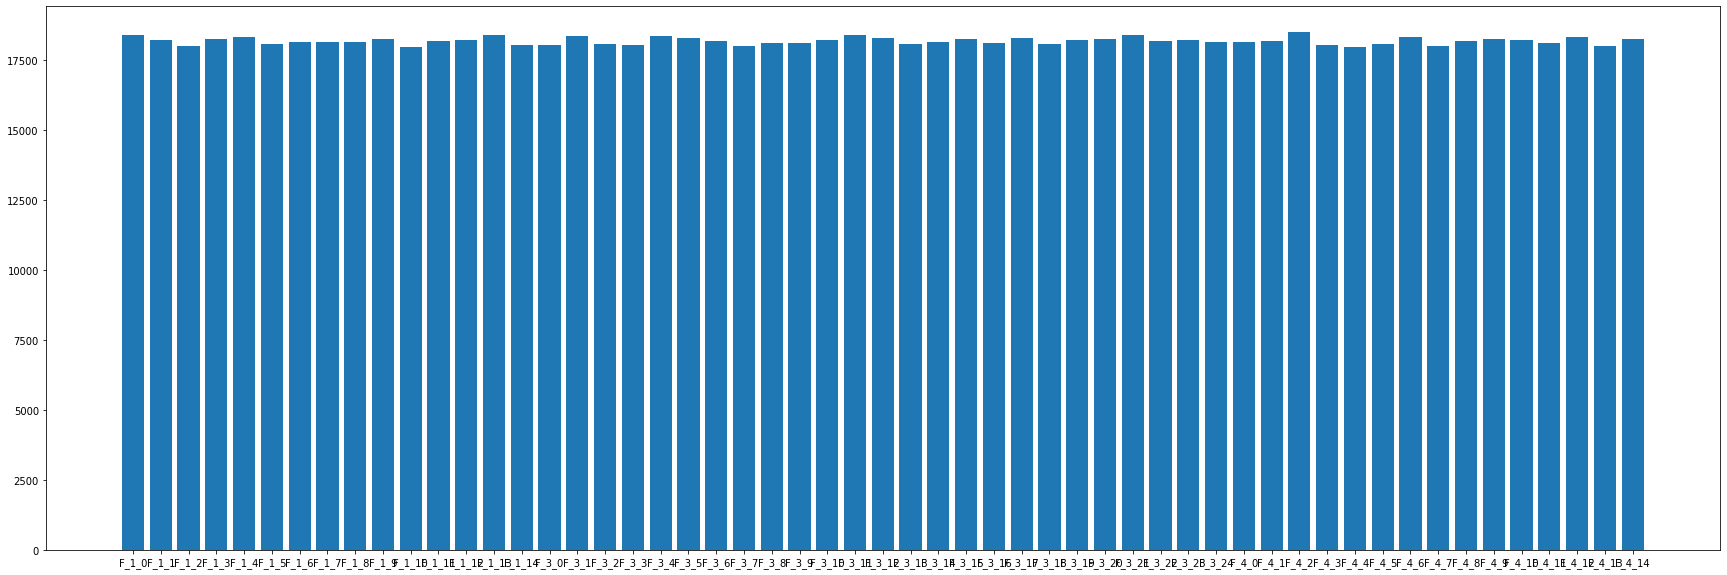

In [7]:
columns = df_nans.columns
fig = plt.figure(figsize=(30, 10))
plt.bar(x=columns, height = np.isnan(df_nans).sum())
plt.show()

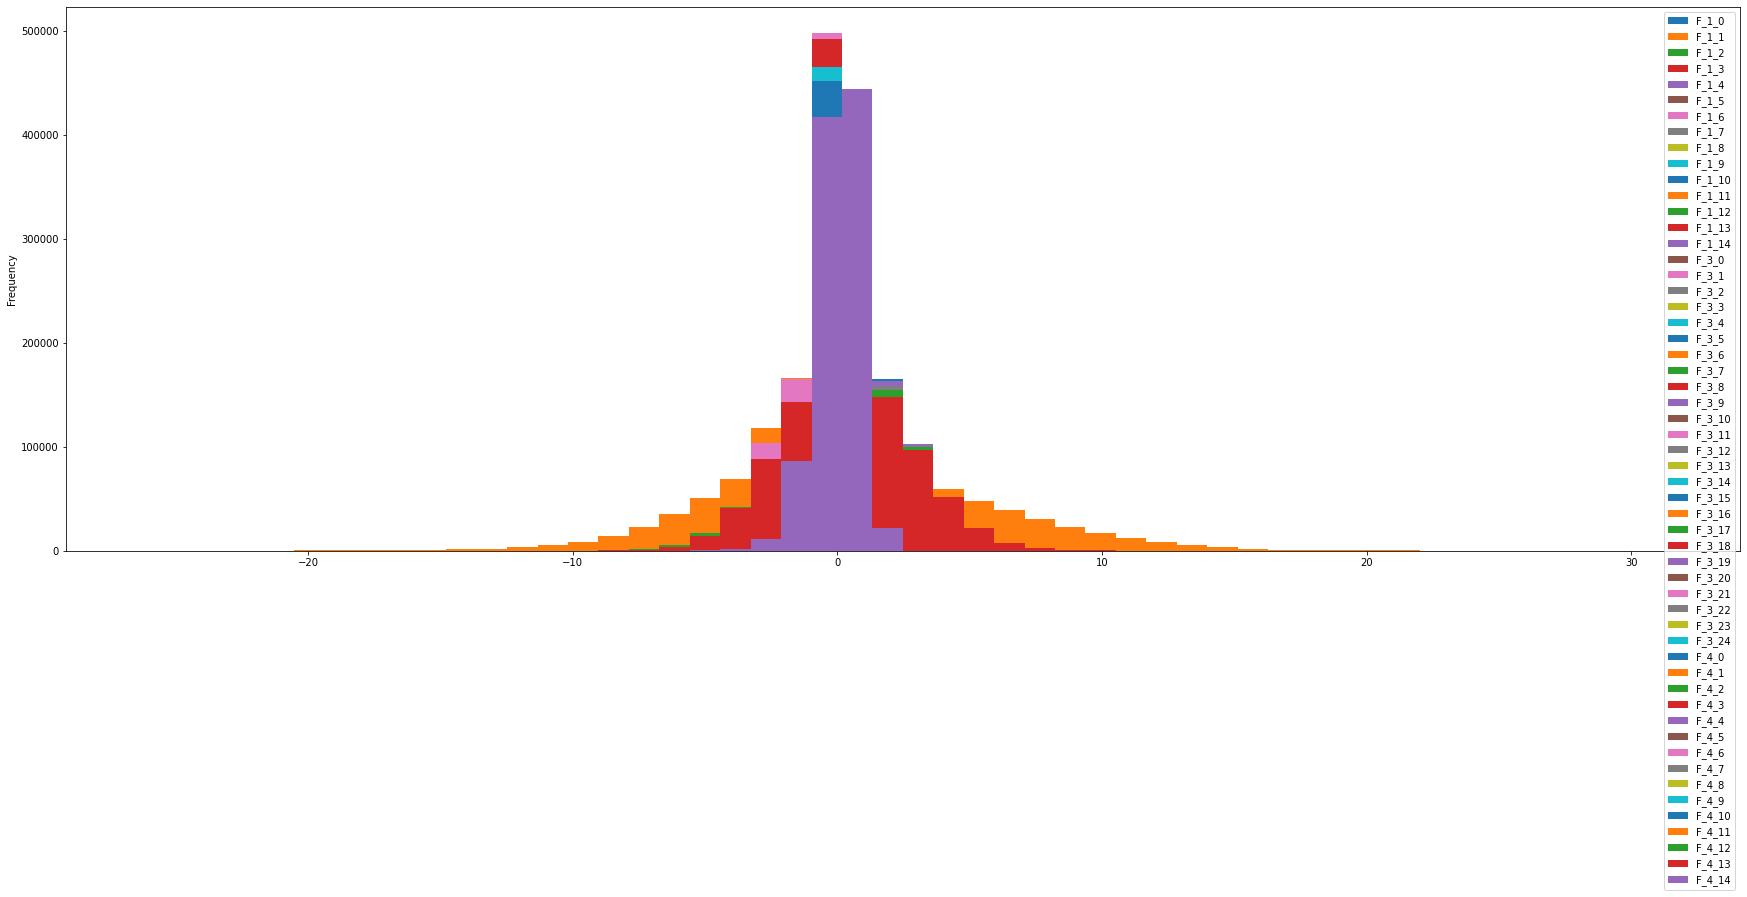

In [8]:
df_nans.plot.hist(figsize=(30, 10), bins = 50)
plt.show()

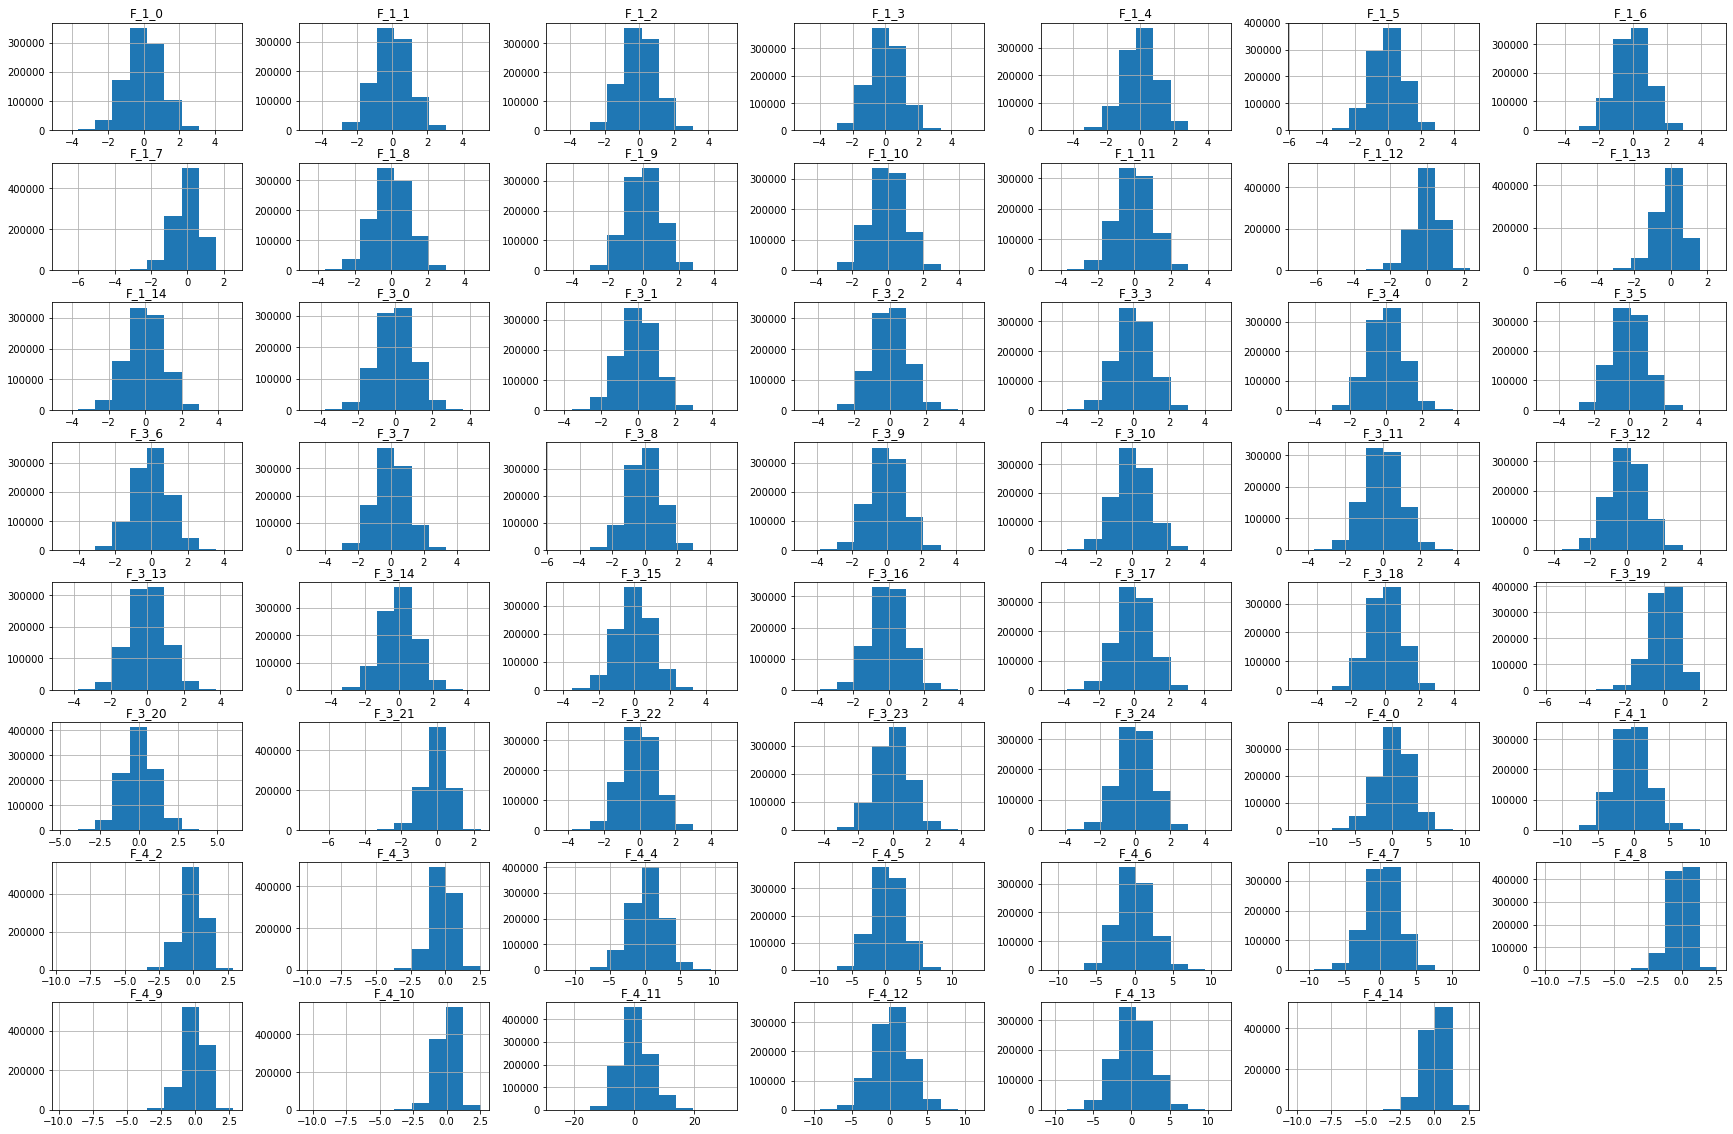

In [9]:
df_nans.hist(figsize=(30, 20))
plt.show()

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_data = scaler.fit_transform(df.drop('row_id', axis = 1))

In [11]:
BUFFER_SIZE = 900000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Building the GAIN

## Define the Generator

In [12]:
def generator_builder(num_fet = 80):
  generator = keras.models.Sequential([
    keras.layers.Input(shape = num_fet * 2), 
    keras.layers.Dense(150, 'relu'),
    keras.layers.Dense(100, 'relu'),
    keras.layers.Dense(80, 'sigmoid')
  ])
  return generator

## Define the Discriminator

In [13]:
def discriminator_builder(num_fet = 80):
  discriminator = keras.models.Sequential([
      keras.layers.Input(shape = num_fet * 2),
      keras.layers.Dense(150, 'relu'),
      keras.layers.Dense(100, 'relu'),
      keras.layers.Dense(80, 'sigmoid'),
  ])
  return discriminator

Discriminarot Loss 

In [14]:
def discriminator_loss(m, m_hat):
  temp = tf.math.multiply(m, tf.math.log(m_hat + 1e-8))
  temp += tf.math.multiply(tf.ones_like(m) - m , tf.math.log(tf.ones_like(m_hat) - m_hat + 1e-8))
  return -tf.reduce_mean(temp)

Generator Loss

In [15]:
def generator_loss(m, m_hat, x, x_hat, alpha = 10):
  loss = -tf.math.multiply((tf.ones_like(m)-m), tf.math.log(m_hat+1e-8))
  loss += alpha * tf.multiply(m, (x - x_hat) ** 2)
  return tf.reduce_mean(loss)

In [16]:
def hint_smapler(batch_size = 128, num_fet = 80, hint_rate = 0.9):
    A = np.random.uniform(0., 1., size = [batch_size, num_fet])
    B = hint_rate > A
    C = 1.*B
    return C

Define the Optimizers and build the models

In [17]:
generator_optimizer = keras.optimizers.SGD(1e-4)
discriminator_optimizer = keras.optimizers.SGD(1e-4)

In [18]:
generator = generator_builder()
discriminator = discriminator_builder()

In [19]:
@tf.function
def train_step(batch, epoch_num):
    
  m = tf.where(tf.math.is_nan(batch), tf.zeros_like(batch), tf.ones_like(batch))
  batch_C = tf.where(tf.math.is_nan(batch), tf.zeros_like(batch), batch)
  z = np.random.uniform(0, 0.01, size = batch.shape)
  batch = tf.math.multiply(batch_C, m) + tf.math.multiply((tf.ones_like(m) - m), z)
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    X_temp = tf.cast(generator(tf.concat([batch, m], 1), training = True), tf.float64)
    X_hat = tf.math.multiply(m, batch) + tf.math.multiply((tf.ones_like(m) - m), X_temp)

    H = tf.math.multiply(hint_smapler(),  m)
    M_hat = tf.cast(discriminator(tf.concat([X_hat, H], 1), training = True), tf.float64)

    disc_loss = discriminator_loss(m, M_hat)
    gen_loss = generator_loss(m, M_hat, batch, X_hat, alpha = 10)

  gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gen_grad, generator.trainable_variables))
  discriminator_optimizer.apply_gradients((zip(disc_grad, discriminator.trainable_variables)))
  return gen_loss, disc_loss

In [20]:
def train(dataset, EPOCHS):
  losses_gen = []
  losses_disc  = []
  for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch} / {EPOCHS}:', end=' ')
    t0 = time.time()
    for batch in dataset:
      gen_loss, disc_loss = train_step(batch, epoch)
      losses_gen.append(gen_loss)
      losses_disc.append(disc_loss)
    t1 = time.time()
    print(f'gen_loss = {gen_loss}, disc_loss = {disc_loss}, time = {t1 - t0}')
  return losses_gen, losses_disc

In [21]:
gen_loss, disc_loss = train(train_dataset, EPOCHS = 10)

Epoch 1 / 10: gen_loss = 0.008152496760730757, disc_loss = 0.6195893851523107, time = 39.02541661262512
Epoch 2 / 10: gen_loss = 0.0055619357497939, disc_loss = 0.5012547375137784, time = 82.00876092910767
Epoch 3 / 10: gen_loss = 0.0037008378711405805, disc_loss = 0.3689048752165748, time = 41.05525732040405
Epoch 4 / 10: gen_loss = 0.002638205757878, disc_loss = 0.23968942640531782, time = 40.48276996612549
Epoch 5 / 10: gen_loss = 0.0018783184182737105, disc_loss = 0.15685901725291065, time = 39.244823932647705
Epoch 6 / 10: gen_loss = 0.000996611655993217, disc_loss = 0.11212292646148007, time = 41.05267119407654
Epoch 7 / 10: gen_loss = 0.0005585038380976098, disc_loss = 0.08486780220348893, time = 41.047319412231445
Epoch 8 / 10: gen_loss = 0.000552123774536105, disc_loss = 0.08410286266268625, time = 41.05071520805359
Epoch 9 / 10: gen_loss = 0.00035425082999153955, disc_loss = 0.06586815119840829, time = 41.05311965942383
Epoch 10 / 10: gen_loss = 0.00037204644885486865, disc_l

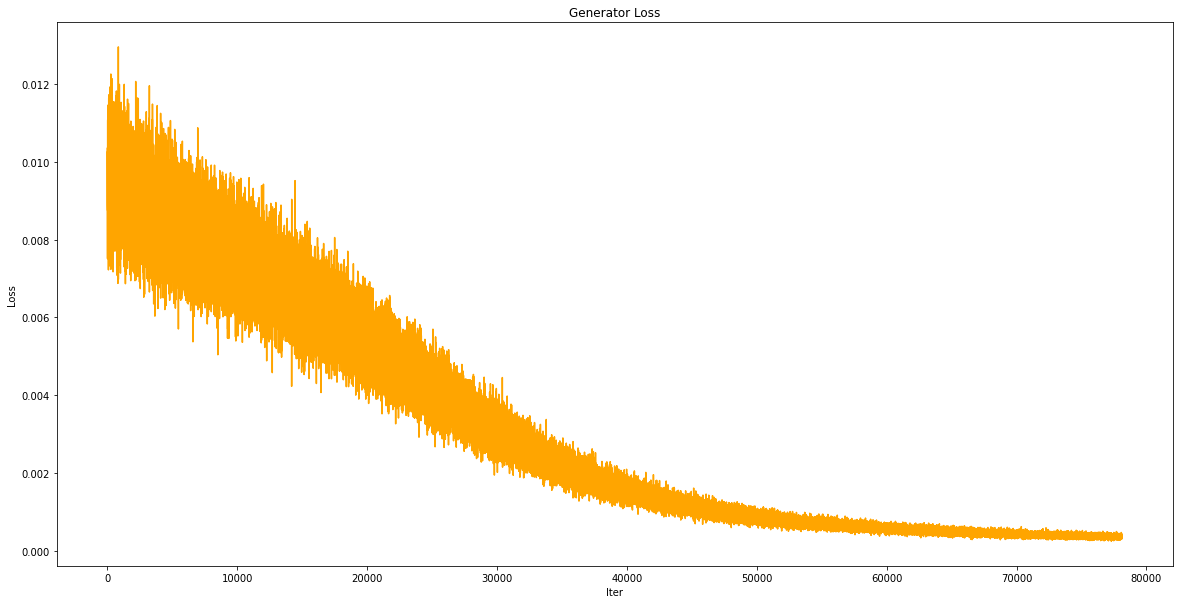

In [22]:
plt.figure(figsize = (20, 10))
plt.plot(gen_loss, color = 'orange')
plt.title('Generator Loss')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

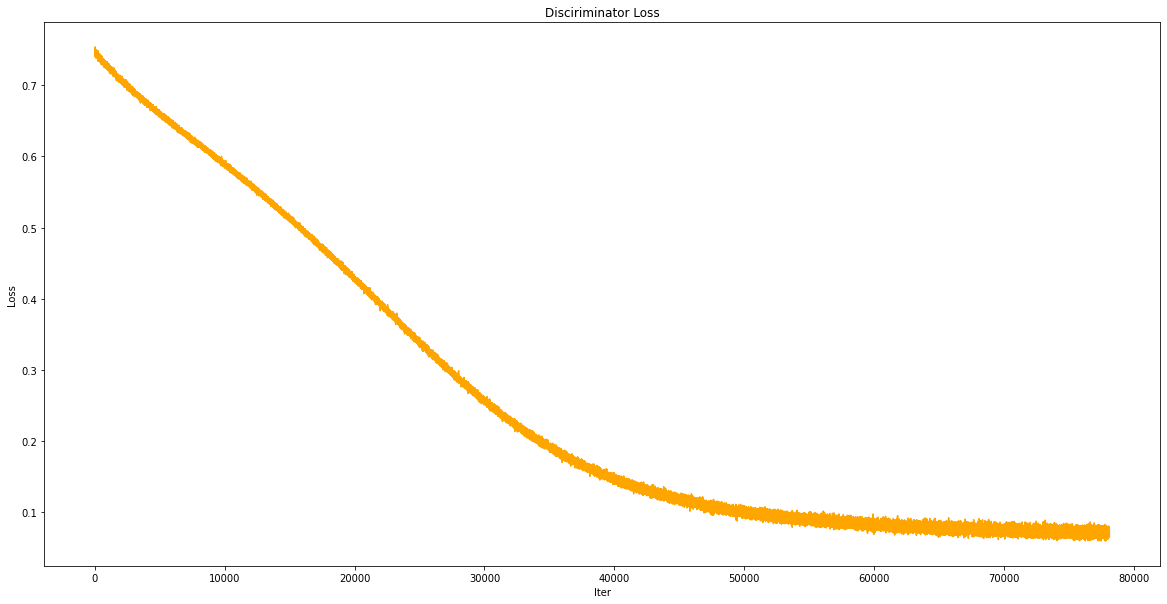

In [23]:
plt.figure(figsize = (20, 10))
plt.plot(disc_loss, color = 'orange')
plt.title('Disciriminator Loss')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

In [24]:
m = tf.where(tf.math.is_nan(train_data), tf.zeros_like(train_data), tf.ones_like(train_data))
train_data_C = tf.where(tf.math.is_nan(train_data), tf.zeros_like(train_data), train_data)
z = np.random.uniform(0, 0.01, size = train_data.shape)
train_data = tf.math.multiply(train_data_C, m) + tf.math.multiply((tf.ones_like(m) - m), z)

In [25]:
X_temp = tf.cast(generator(tf.concat([train_data, m], 1), training = True), tf.float64)
X_hat = tf.math.multiply(m, train_data) + tf.math.multiply((tf.ones_like(m) - m), X_temp) 

In [26]:
pred = scaler.inverse_transform(X_hat)
df_ = df.drop(['row_id'], axis = 1)
test = []
for idx_col, col in enumerate(df):
  for idx_row, row in enumerate(df.loc[:, col]):
    if np.isnan(row):
      test.append(f'{idx_row}-{col}')
res = []
for col_idx, col in enumerate(df_):
  for row_idx, row in enumerate(df_.loc[:, col]):
    if np.isnan(row):
      res.append(pred[row_idx, col_idx])

In [27]:
out = np.array([test, res])
out = pd.DataFrame(out.T)
out = out.rename({0: 'row-col', 1: 'value'}, axis = 1)
out.to_csv('results.csv', index = False)